In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# === 设置中文字体 ===
plt.rcParams['font.family'] = 'SimHei'   # 使用黑体（可选：'Microsoft YaHei', 'Arial Unicode MS' 等）
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# === 忽略所有警告（包括字体警告）===
warnings.filterwarnings("ignore")

# 引言
近年来，截面策略（Cross-Sectional Strategy）作为量化投资的主流方法，通过因子
排序组成多头股票组合的方式在公募量化领域得到广泛应用。然而，随着市场发展，此类
策略正面临新的挑战。一方面，传统财务、量价等基础因子的挖掘已趋于饱和，模型迭代
和升级的边际收益持续递减；另一方面，在市场剧烈波动时期，如，2024 年 9-10 月间，
各类因子同步失效导致截面策略集体回撤。

面对这些挑战，市场将目光投向了与截面策略具有不同收益来源的其他策略，例如，
时序策略（Time-Series Strategy）。区别于截面策略的横向比较排序的选股逻辑，时序
策略通常是在选定的资产池内，通过动态调整资产权重来捕捉趋势性机会。这类策略往往
不依赖于资产间的相对排名，从而可能在因子集体失效时展现出更好的抗风险能力。

从上述想法出发，本文聚焦宽基指数组合，尝试构建一类日内和隔夜的时序交易策略。
首先，我们在指数层面进行了不同假设下，策略的构建与测试，随后引入 ETF 作为实际
交易资产，进一步评估策略在实操环境下的收益表现与风险控制能力。最后，本文从收益
特征的角度出发，对比时序策略与典型截面策略，重点关注其在收益结构，以及不同市场
环境下的稳健性表现。

# 数据获取

In [2]:
# === 1. 读取并预处理数据 ===
df = pd.read_excel("data.xlsx", sheet_name="Sheet1")

# 向下填充指数代码
df['order_book_id'] = df['order_book_id'].ffill()

# 转换时间字段
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time


# 指数的日内特征
日度收益的预测难度颇大，但日内的规律往往有迹可循。例如，若把日内的交易时间
按照每半个小时为单位分隔，再将每日同个半小时的收益分别累计，确实可以观察到一些
有趣的现象：某些特定时段，指数的表现不依赖于当日的涨跌，而呈现出较为稳定的趋势。

## “神奇”2点半
以沪深 300（图 1）和中证 1000（图 2）为例，在 13:30 至 14:00 和 14:30 至 15:00
这两个时间段，指数的涨跌在日与日之间表现出较为一致的特征。13:30 至 14:00，普遍
表现低迷，累计净值（红色曲线）呈缓慢下行趋势；14:30 至 15:00，指数上涨概率较大，
累计净值（金色曲线）的上行趋势尤为稳定和显著。

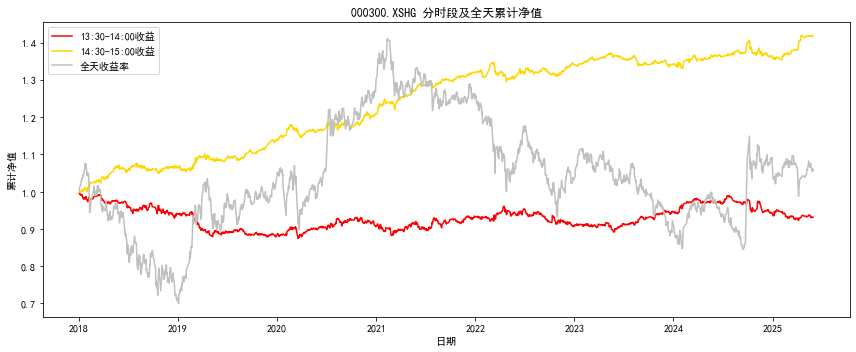

In [3]:
# === 2. 筛选目标指数 ===
target_index = "000300.XSHG"  # 可替换为其他代码，如 "000300.XSHG"
df1 = df[df['order_book_id'] == target_index].copy()

# 计算每半小时收益率
df1['return'] = df1['close'].pct_change()
df1 = df1.dropna().reset_index(drop=True)


# === 3. 分段收益函数 ===
def extract_segment_return(df, start_time, end_time):
    mask = (df['time'] > start_time) & (df['time'] <= end_time)
    segment = df[mask].copy()
    segment['date'] = pd.to_datetime(segment['date'])
    segment_return = segment.groupby('date')['return'].sum().sort_index()
    return segment_return

# 提取分段 & 全日收益

r_1330_1400 = extract_segment_return(df1, pd.to_datetime("13:30", format="%H:%M").time(),
                                     pd.to_datetime("14:00", format="%H:%M").time())
r_1430_1500 = extract_segment_return(df1, pd.to_datetime("14:30", format="%H:%M").time(),
                                     pd.to_datetime("15:00", format="%H:%M").time())
r_all_day = df1.groupby('date')['return'].sum().sort_index()

# === 4. 累计净值 ===
def to_cum_nav(returns):
    return 1 + returns.cumsum()

nav_1330_1400 = to_cum_nav(r_1330_1400)
nav_1430_1500 = to_cum_nav(r_1430_1500)
nav_all_day = to_cum_nav(r_all_day)

# === 5. 绘图 ===
plt.figure(figsize=(12, 5))
plt.plot(nav_1330_1400.index, nav_1330_1400.values, label='13:30-14:00收益', color='red')
plt.plot(nav_1430_1500.index, nav_1430_1500.values, label='14:30-15:00收益', color='gold')
plt.plot(nav_all_day.index, nav_all_day.values, label='全天收益率', color='silver')

plt.title(f"{target_index} 分时段及全天累计净值")
plt.xlabel("日期")
plt.ylabel("累计净值")
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

原图1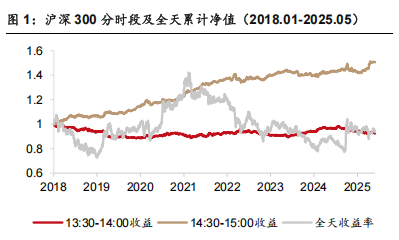

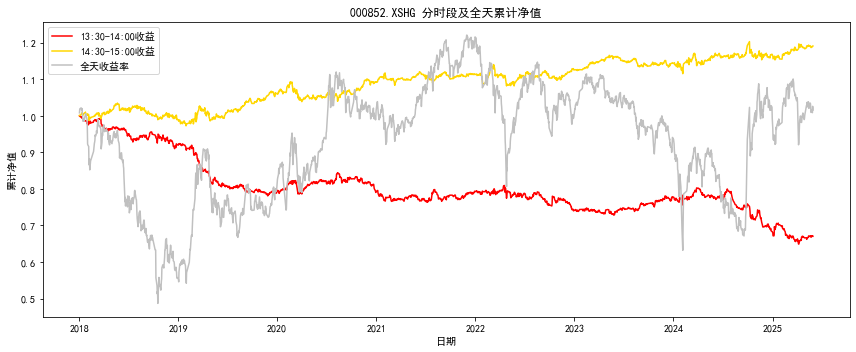

In [4]:
target_index = "000852.XSHG"  # 可替换为其他代码，如 "000300.XSHG"
df1 = df[df['order_book_id'] == target_index].copy()

# 计算每半小时收益率
df1['return'] = df1['close'].pct_change()
df1 = df1.dropna().reset_index(drop=True)


# === 3. 分段收益函数 ===
def extract_segment_return(df, start_time, end_time):
    mask = (df['time'] > start_time) & (df['time'] <= end_time)
    segment = df[mask].copy()
    segment['date'] = pd.to_datetime(segment['date'])
    segment_return = segment.groupby('date')['return'].sum().sort_index()
    return segment_return

# 提取分段 & 全日收益

r_1330_1400 = extract_segment_return(df1, pd.to_datetime("13:30", format="%H:%M").time(),
                                     pd.to_datetime("14:00", format="%H:%M").time())
r_1430_1500 = extract_segment_return(df1, pd.to_datetime("14:30", format="%H:%M").time(),
                                     pd.to_datetime("15:00", format="%H:%M").time())
r_all_day = df1.groupby('date')['return'].sum().sort_index()

# === 4. 累计净值 ===
def to_cum_nav(returns):
    return 1 + returns.cumsum()

nav_1330_1400 = to_cum_nav(r_1330_1400)
nav_1430_1500 = to_cum_nav(r_1430_1500)
nav_all_day = to_cum_nav(r_all_day)

# === 5. 绘图 ===
plt.figure(figsize=(12, 5))
plt.plot(nav_1330_1400.index, nav_1330_1400.values, label='13:30-14:00收益', color='red')
plt.plot(nav_1430_1500.index, nav_1430_1500.values, label='14:30-15:00收益', color='gold')
plt.plot(nav_all_day.index, nav_all_day.values, label='全天收益率', color='silver')

plt.title(f"{target_index} 分时段及全天累计净值")
plt.xlabel("日期")
plt.ylabel("累计净值")
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

原图2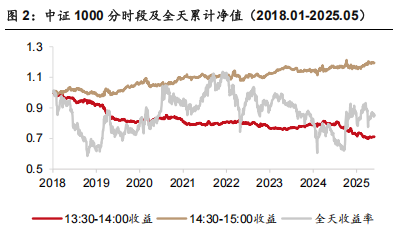

## 基于日内特征的简单交易策略
先不考虑任何实际交易条件的假设下，做一下调仓策略
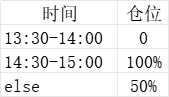


In [5]:
def get_position(t): #调仓函数
    if t > pd.to_datetime("13:30", format="%H:%M").time() and t <= pd.to_datetime("14:00", format="%H:%M").time():
        return 0.0
    elif t > pd.to_datetime("14:30", format="%H:%M").time() and t <= pd.to_datetime("15:00", format="%H:%M").time():
        return 1.0
    else:
        return 0.5

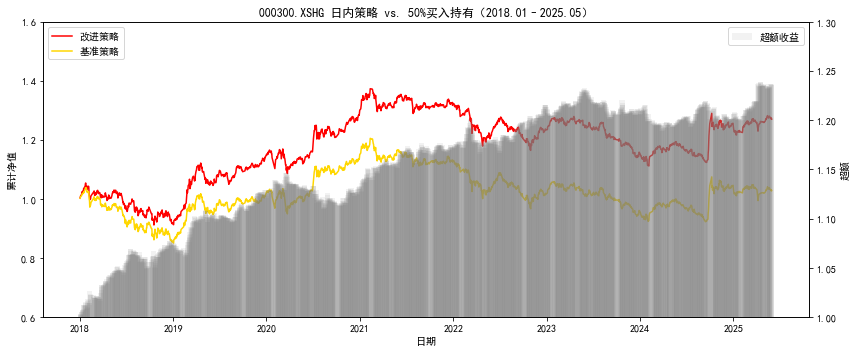

In [6]:
target_index = "000300.XSHG" 
df2 = df[df['order_book_id'] ==target_index].copy()
df2['return'] = df2['close'].pct_change()
df2 = df2.dropna().reset_index(drop=True)
df2['position'] = df2['time'].apply(get_position)

# 计算策略当日收益
df2['weighted_return'] = df2['return'] * df2['position']
strategy_return = df2.groupby('date')['weighted_return'].sum()
benchmark_return = df2.groupby('date')['return'].sum() * 0.5  # 50%持仓买入持有

# === 累计净值 ===
def to_cum_nav(ret):
    return 1 + ret.cumsum()

strategy_nav = to_cum_nav(strategy_return)
benchmark_nav = to_cum_nav(benchmark_return)
excess_nav = strategy_nav / benchmark_nav


# === 绘图：双Y轴 ===
fig, ax1 = plt.subplots(figsize=(12, 5))

# 左轴：净值曲线
ax1.plot(strategy_nav.index, strategy_nav, label="改进策略", color='red',zorder=2)
ax1.plot(benchmark_nav.index, benchmark_nav, label="基准策略", color='gold',zorder=2)
ax1.set_ylabel("累计净值")
ax1.set_xlabel("日期")
ax1.set_ylim(0.6,1.6)
ax1.legend(loc="upper left")

# 右轴：超额柱状图
ax2 = ax1.twinx()
ax2.bar(excess_nav.index, excess_nav, width=20, color='grey', alpha=0.1, label="超额收益",zorder=1)
ax2.set_ylabel("超额")
ax2.set_ylim(1,1.3)
ax2.legend(loc="upper right")

# 图标题
plt.title(f"{target_index} 日内策略 vs. 50%买入持有（2018.01–2025.05）")
plt.tight_layout()
plt.show()

原图3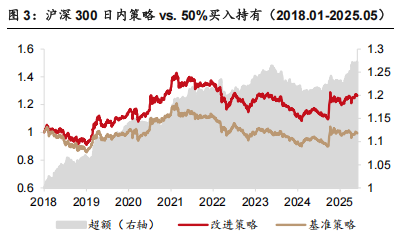

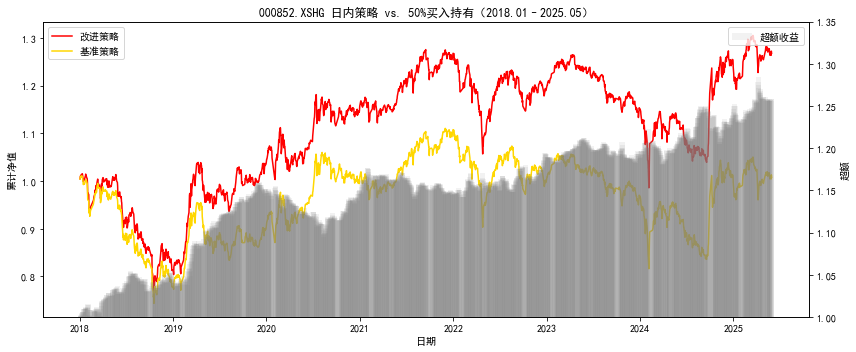

In [7]:
target_index = "000852.XSHG" 
df2 = df[df['order_book_id'] ==target_index].copy()
df2['return'] = df2['close'].pct_change()
df2 = df2.dropna().reset_index(drop=True)
df2['position'] = df2['time'].apply(get_position)

# 计算策略当日收益
df2['weighted_return'] = df2['return'] * df2['position']
strategy_return = df2.groupby('date')['weighted_return'].sum()
benchmark_return = df2.groupby('date')['return'].sum() * 0.5  # 50%持仓买入持有

# === 累计净值 ===
def to_cum_nav(ret):
    return 1 + ret.cumsum()

strategy_nav = to_cum_nav(strategy_return)
benchmark_nav = to_cum_nav(benchmark_return)
excess_nav = strategy_nav / benchmark_nav


# === 绘图：双Y轴 ===
fig, ax1 = plt.subplots(figsize=(12, 5))

# 左轴：净值曲线
ax1.plot(strategy_nav.index, strategy_nav, label="改进策略", color='red',zorder=2)
ax1.plot(benchmark_nav.index, benchmark_nav, label="基准策略", color='gold',zorder=2)
ax1.set_ylabel("累计净值")
ax1.set_xlabel("日期")
ax2.set_ylim(0.6,1.4)
ax1.legend(loc="upper left")

# 右轴：超额柱状图
ax2 = ax1.twinx()
ax2.bar(excess_nav.index, excess_nav, width=20, color='grey', alpha=0.1, label="超额收益",zorder=1)
ax2.set_ylabel("超额")
ax2.set_ylim(1,1.35)
ax2.legend(loc="upper right")

# 图标题
plt.title(f"{target_index} 日内策略 vs. 50%买入持有（2018.01–2025.05）")
plt.tight_layout()
plt.show()

原图4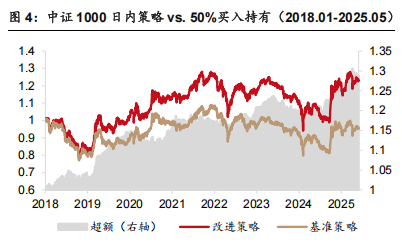

In [8]:
target_index = "000300.XSHG" 
df2 = df[df['order_book_id'] ==target_index].copy()
df2['return'] = df2['close'].pct_change()
df2 = df2.dropna().reset_index(drop=True)
df2['position'] = df2['time'].apply(get_position)

# 计算策略当日收益
df2['weighted_return'] = df2['return'] * df2['position']
strategy_return = df2.groupby('date')['weighted_return'].sum()
benchmark_return = df2.groupby('date')['return'].sum() * 0.5  # 50%持仓买入持有

# === 累计净值 ===
def to_cum_nav(ret):
    return 1 + ret.cumsum()

strategy_nav = to_cum_nav(strategy_return)
benchmark_nav = to_cum_nav(benchmark_return)
nav_df = pd.DataFrame({
    "strategy": strategy_nav,
    "benchmark": benchmark_nav
})
nav_df['year'] = pd.to_datetime(nav_df.index).year

def max_drawdown(series):
    cummax = series.cummax()
    drawdown = 1 - series / cummax
    return drawdown.max()

# === 年度统计表构建 ===
rows = []
for year, group in nav_df.groupby('year'):
    start = group.iloc[0]
    end = group.iloc[-1]
    strategy_rtn = end['strategy'] / start['strategy'] - 1
    benchmark_rtn = end['benchmark'] / start['benchmark'] - 1
    excess = strategy_rtn - benchmark_rtn

    strat_dd = max_drawdown(group['strategy'])
    bench_dd = max_drawdown(group['benchmark'])

    rows.append({
        "年份": str(year),
        "策略收益率": f"{strategy_rtn * 100:.2f}%",
        "基准收益率": f"{benchmark_rtn * 100:.2f}%",
        "超额收益率": f"{excess * 100:.2f}%",
        "策略最大回撤": f"{strat_dd * 100:.2f}%",
        "基准最大回撤": f"{bench_dd * 100:.2f}%"
    })

# 全区间汇总
full_start = nav_df.iloc[0]
full_end = nav_df.iloc[-1]
n_years = (full_end.name - full_start.name).days / 365.25
#strategy_ann = (full_end['strategy'] / full_start['strategy']) ** (1 / n_years) - 1
#benchmark_ann = (full_end['benchmark'] / full_start['benchmark']) ** (1 / n_years) - 1

strategy_ann = (full_end['strategy']) ** (1 / n_years) - 1
benchmark_ann = (full_end['benchmark']) ** (1 / n_years) - 1
excess = strategy_ann - benchmark_ann
strat_dd = max_drawdown(nav_df['strategy'])
bench_dd = max_drawdown(nav_df['benchmark'])

rows.append({
    "年份": "全区间",
    "策略收益率": f"{strategy_rtn * 100:.2f}%",
    "基准收益率": f"{benchmark_rtn * 100:.2f}%",
    "超额收益率": f"{excess * 100:.2f}%",
    "策略最大回撤": f"{strat_dd * 100:.2f}%",
    "基准最大回撤": f"{bench_dd * 100:.2f}%"
})

# === 6. 输出结果表 ===
annual_table = pd.DataFrame(rows)
annual_table

,年份,策略收益率,基准收益率,超额收益率,策略最大回撤,基准最大回撤
0,2018,-8.34%,-14.40%,6.05%,13.52%,17.68%
1,2019,25.68%,19.77%,5.91%,6.78%,6.96%
2,2020,12.89%,12.13%,0.76%,7.14%,8.30%
3,2021,1.45%,-2.17%,3.62%,6.11%,8.00%
4,2022,-6.66%,-9.85%,3.19%,11.92%,14.34%
5,2023,-6.20%,-5.73%,-0.47%,10.91%,11.09%
6,2024,8.41%,8.78%,-0.36%,5.93%,7.69%
7,2025,2.92%,0.48%,2.44%,3.35%,5.19%
8,全区间,2.92%,0.48%,2.91%,19.07%,23.47%


原表1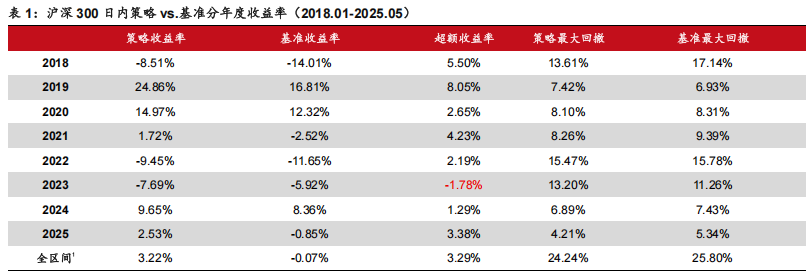
<font color=red>注：原数据中累积基准收益率为2.54%，但年化收益率为-0.07%</font>

以沪深 300 为例，除 2023、2024 年外，日内调仓策略在其余年份均实现了正的收益增厚。但若进一步将实际交易条件纳入考量，假设单边交易费率介于万 0.5 至万 1 之间，测算策略的费后收益。由图 5 可见，即便费率设为单边万 0.5，策略的年化收益率也仅为0.77%，高于基准的0.48%；而如果费率升至单边万 1，策略的费后收益甚至低于基准。因此，一旦引入交易成本，较为可观的收益增厚优势被大幅削弱。

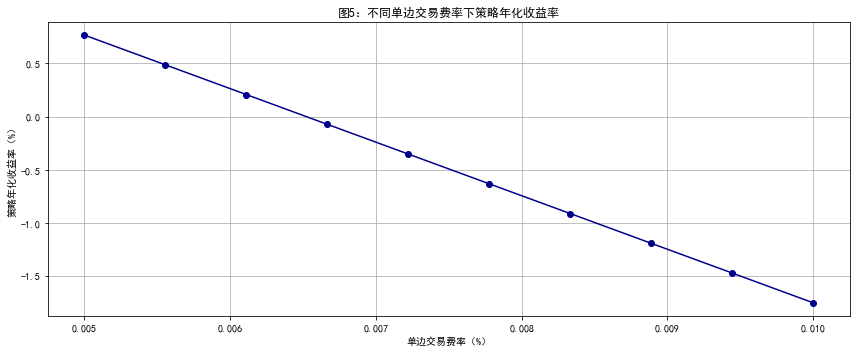

In [20]:
df2['position'] = df2['time'].apply(get_position)
df2['prev_position'] = df2['position'].shift(1)
df2['turnover'] = (df2['position'] - df2['prev_position']).abs().shift(-1).fillna(0)
df2['weighted_return'] = df2['return'] * df2['position']

# === 汇总换手 ===
daily_ret = df2.groupby('date')['weighted_return'].sum()
daily_turnover = df2.groupby('date')['turnover'].sum()

# === 测试不同费率下的年化收益 ===
fee_rates = np.linspace(0.00005, 0.0001, 10)  # 从 0 到 0.5%，共21点
ann_returns = []

#原文计算方法为策略年化收益率-平均每日换手手续费*252（假设一年252天）
for fee in fee_rates:
    cost = daily_turnover * fee
    ann_ret = strategy_ann - cost.mean()*252
    ann_returns.append(ann_ret*100)

# === 绘图 ===
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(fee_rates * 100, ann_returns, marker='o', color='darkblue')
ax.set_title("图5：不同单边交易费率下策略年化收益率")
ax.set_xlabel("单边交易费率（%）")
ax.set_ylabel("策略年化收益率（%）")
ax.grid(True)
plt.tight_layout()
plt.show()


原图5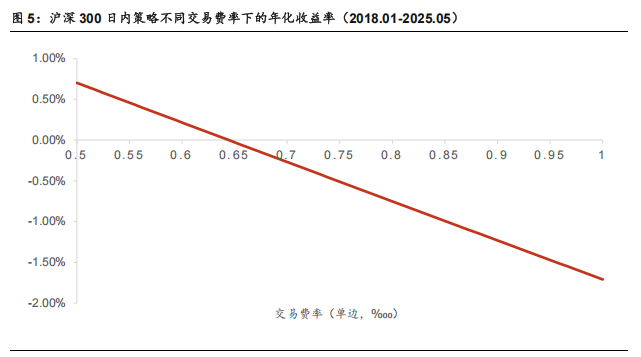